# Thesis data cleaning and visualisation

**Peter Horn, CEU** 

- Code for Data cleaning process and data visualisation 
- Data available: http://www.enable-eu.com/dataset-on-households-energy-use-now-available/

In [107]:
%config IPCompleter.greedy=True
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy import stats
import os

In [108]:
os.chdir("C:/Users/T440s/Google Drive/CEU/Thesis")

In [109]:
data_main = pd.read_stata("data/ENABLE.EU_dataset_survey_of_households.dta")

## Data wrangling

In [110]:
data_main = data_main.replace(["Do not know", "NaN", 99, "Refusal"], np.nan)

In [111]:
cols_tostring = ['Country', 'H1', 'H2', 'H3', 'H5A1', 'H5A2', 
                 'H5A3', 'H5A4', 'H5A99','H15A', 'H15B', 'H15D', 
                 'S2','S4','S4','H11A','G1A1', 'G1A2','G1A3',
                 'G1A4','G1A5', 'G2A1', 'G2A2','G2A3','G2A4',
                 'G2A5','G2A6','E6A1', 'E6A2', 'E6A3', 'E6A4',
                 'G5A','G5B','G5C','G5D','G5E', 'C1A', 'C3', 'T3', 
                'T2', 'M1A', 'M1B', 'M1C', 'M1D']

cols_tofloat = ['H8A', 'H7A1', 'H7AA', 'S4']

def change_type(data, strs, floats):
    
    for col in strs:
        data[col] = data[col].astype('str')
        
    for col in floats:
        data[col] = data[col].astype('float')
        
    return data

data_main = change_type(data_main, cols_tostring, cols_tofloat)

In [112]:
for row in range(len(data_main)):
    data_main["H3"].iloc[row] = data_main["H3"].iloc[row].replace("\x96", "to")

C:\Users\T440s\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


**Filtering non-usable cols (too much missing)**

In [113]:
for var in data_main:
    if data_main[var].isna().sum()/len(data_main) > 0.8:
        data_main.drop(var, axis=1, inplace = True)

**Filtering countries without Q-s regarding ef. attitudes**

In [114]:
data_main = data_main[
    (data_main["Country"] != "Bulgaria")
    & (data_main["Country"] != "Italy")
    & (data_main["Country"] != "Spain")
].reset_index(drop = True)

## Descriptives

### Building Characteristics

In [115]:
insulation = pd.DataFrame.from_dict(
    {
        "Attic and roof insulation": data_main["H5A1"][
            data_main["H5A1"] == "Mentioned"
        ].count(),
        "Cavity wall insulation": data_main["H5A2"][
            data_main["H5A2"] == "Mentioned"
        ].count(),
        "External wall insulation": data_main["H5A3"][
            data_main["H5A3"] == "Mentioned"
        ].count(),
        "No additional insulation": data_main["H5A4"][
            data_main["H5A4"] == "Mentioned"
        ].count(),
        "(Don’t know)": data_main["H5A99"][data_main["H5A99"] == "Mentioned"].count(),
    },
    orient="index",
)

In [116]:
 def house_type(row):
        
        if row['H1'] == 'Apartment in a building with 6 or more flats':
            return 0
        if row['H1'] == 'Single-family house attached to one or more other houses (for example: duplex, r':
            return 1
        if row['H1'] == 'Single-family house detached from any other house':
            return 2
        if row['H1'] == 'Apartment in a building with 2 to 5 flats':
            return 3
        else:
            return np.nan
        
data_main['house_type'] = data_main.apply(lambda row: house_type(row), axis = 1)

In [117]:
data_main["detached"] = np.where(data_main["house_type"] == 2, 1, 0)
data_main.loc[data_main["house_type"].isna(), "detached"] = np.nan

data_main["semi_detached"] = np.where(data_main["house_type"] == 1, 1, 0)
data_main.loc[data_main["house_type"].isna(), "semi_detached"] = np.nan

data_main["non_detached"] = np.where((data_main["house_type"] == 3) | (data_main["house_type"] == 0), 1, 0)
data_main.loc[data_main["house_type"].isna(), "semi_detached"] = np.nan

In [118]:
def house_size(row):

    if row["H3"] == "Up to 42 m2":
        return 0
    if row["H3"] == "43 to 65 m2":
        return 1
    if row["H3"] == "66 to 90 m2":
        return 2
    if row["H3"] == "91 to 120 m2":
        return 3
    if row["H3"] == "120 to 200 m2":
        return 4
    if row["H3"] == "More than 200 m2":
        return 5
    else:
        return np.nan


data_main["house_size"] = data_main.apply(lambda row: house_size(row), axis=1)


def house_age(row):

    if row["H2"] == "Before 1950":
        return 7
    if row["H2"] == "1950 to 1959":
        return 6
    if row["H2"] == "1960 to 1969":
        return 5
    if row["H2"] == "1970 to 1979":
        return 4
    if row["H2"] == "1980 to 1989":
        return 3
    if row["H2"] == "1990 to 1999":
        return 2
    if row["H2"] == "2000 to 2009":
        return 1
    if row["H2"] == "2010 to 2016":
        return 0
    else:
        return np.nan


data_main["house_age"] = data_main.apply(lambda row: house_age(row), axis=1)

In [119]:
data_main['before_1980'] = np.where(data_main['house_age'] >= 4, 1,0)
data_main.loc[data_main['house_age'].isna(), 'before_1980'] = np.nan

data_main['before_1990'] = np.where(data_main['house_age'] >= 3, 1,0)
data_main.loc[data_main['house_age'].isna(), 'before_1990'] = np.nan

data_main['house_big'] = np.where(data_main['house_size'] >= 3, 1,0)
data_main.loc[data_main['house_size'].isna(), 'house_big'] = np.nan

### Social characteristics

In [120]:
data_main["household_members"] = (
    data_main["S1Ac1"]
    + data_main["S1Ac2"]
    + data_main["S1Ac3"]
    + data_main["S1Bc1"]
    + data_main["S1Bc2"]
    + data_main["S1Bc3"]
)
data_main["children"] = data_main["S1Ac1"] + data_main["S1Bc1"]
data_main["middle_aged"] = data_main["S1Ac2"] + data_main["S1Bc2"]
data_main["elderly"] = data_main["S1Ac3"] + data_main["S1Bc3"]
data_main["resp_age"] = 2018 - data_main["S4"]

In [121]:
def income_decile(row):

    if (
        (row["S9MONTH"] == "Bracket 1")
        | (row["S9MONTH"] == "Bracket 2")
        | (row["S9YEAR"] == "Bracket 1")
        | (row["S9YEAR"] == "Bracket 2")
    ):
        return "Poor"
    if (
        (row["S9MONTH"] == "Bracket 3")
        | (row["S9MONTH"] == "Bracket 4")
        | (row["S9YEAR"] == "Bracket 3")
        | (row["S9YEAR"] == "Bracket 4")
    ):
        return "Low income"
    if (
        (row["S9MONTH"] == "Bracket 5")
        | (row["S9MONTH"] == "Bracket 6")
        | (row["S9YEAR"] == "Bracket 5")
        | (row["S9YEAR"] == "Bracket 6")
    ):
        return "Lower middle income"
    if (
        (row["S9MONTH"] == "Bracket 7")
        | (row["S9MONTH"] == "Bracket 8")
        | (row["S9YEAR"] == "Bracket 7")
        | (row["S9YEAR"] == "Bracket 8")
    ):
        return "Upper middle income"
    if (
        (row["S9MONTH"] == "Bracket 9")
        | (row["S9MONTH"] == "Bracket 10")
        | (row["S9YEAR"] == "Bracket 9")
        | (row["S9YEAR"] == "Bracket 10")
    ):
        return "High income"
    if (row["S9MONTH"] == "Refused to answer") | (row["S9YEAR"] == "Refused to answer"):
        return "Do not know / Refusal"
    else:
        return "Do not know / Refusal"


data_main["income_decile"] = data_main.apply(lambda row: income_decile(row), axis=1)

In [122]:
data_main["income_decile_num10"] = np.nan
data_main["income_decile_num10"] = np.where(
    data_main["S9MONTH"].notna(), data_main["S9MONTH"], data_main["income_decile_num10"]
)
data_main["income_decile_num10"] = np.where(
    data_main["S9YEAR"].notna(), data_main["S9YEAR"], data_main["income_decile_num10"]
)

In [123]:
def gender(row):

    if row["S5"] == "Male":
        return 0
    if row["S5"] == "Female":
        return 1
    else:
        return np.nan
    
data_main['gender'] = data_main.apply(lambda row: gender(row), axis = 1)

In [124]:
def education(row):

    if row["S2"] == "No formal education or below primary":
        return 0
    if row["S2"] == "Primary education":
        return 1
    if row["S2"] == "Secondary  and post-secondary non-tertiary education":
        return 2
    if row["S2"] == "Tertiary education first stage, i.e. bachelor or master":
        return 3
    if row["S2"] == "Tertiary education second stage (PhD)":
        return 4
    if row["S2"] == "Do not know / Refusal":
        return np.nan
    else:
        return np.nan
    
data_main['education'] = data_main.apply(lambda row: education(row), axis=1)

In [125]:
data_main["rural"] = np.where(
    (data_main["S6"] == "The suburbs or outskirts of a big city")
    | (data_main["S6"] == "A big city (more than 0,5 mln people)"), 0,1
)
data_main.loc[data_main["S6"].isna(), "rural"] = np.nan

In [131]:
def resp_age(row):
    
    if row['resp_age'] <= 39:
        return '30-39'
    if ((row['resp_age'] >= 40) & (row['resp_age'] <= 49)):
        return '40-49'
    if ((row['resp_age'] >= 50) & (row['resp_age'] <= 59)):
        return '50-59'
    if ((row['resp_age'] >= 60) & (row['resp_age'] <= 69)):
        return '60-69'    
    if ((row['resp_age'] >= 70) & (row['resp_age'] <= 79)):
        return '70-79'    
    if (row['resp_age'] >= 80):
        return '80-93'
    else:
        return np.nan
    
data_main['resp_age_bins'] = data_main.apply(lambda row: resp_age(row), axis=1)

### Appliances

In [132]:
data_main["appliance_age_avg"] = np.nan


def age_count(df):
    appliance = ["H11A", "H11B", "H11C", "H11D", "H11E", "H11F", "H11G", "H11H"]
    age = 0
    no_app = 0

    for i in appliance:
        if df[i] == "Up to 3 years old":
            age += 1
        elif df[i] == "4-10 years old":
            age += 2
        elif df[i] == "Older than 10 years":
            age += 3
        elif (df[i] == "Do not have") | (pd.isnull(df[i])):
            # print(df[i])
            no_app += 1

    if no_app < len(appliance):
        return age / (len(appliance) - no_app)
    elif no_app == len(appliance):
        return np.nan


data_main["appliance_age_avg"] = data_main.apply(age_count, axis=1)

In [143]:
def ef_bulbs(row):

    if row["H12B"] == "nan":
        return np.nan
    if row["H12B"] == "All":
        return 1
    if row["H12B"] == "Most":
        return 0.75
    if row["H12B"] == "About half":
        return 0.5
    if row["H12B"] == "Some":
        return 0.25
    if row["H12B"] == "None":
        return 0


data_main["ef_bulbs"] = data_main.apply(lambda row: ef_bulbs(row), axis=1)

In [138]:
smart_meter = pd.DataFrame.from_dict(
    {
        "Electricity smart meter": data_main["H13A"][
            data_main["H13A"] == "Yes"
        ].count(),
        "Gas smart meter": data_main["H13B"][data_main["H13B"] == "Yes"].count(),
        "Heating smart meter": data_main["H13C"][data_main["H13C"] == "Yes"].count(),
    },
    orient="index",
)

In [146]:
def green(df):
    if df == "Not Mentioned":
        return 0
    elif df == "Mentioned":
        return 1
    else:
        return np.nan


greens = ["green_1", "green_2", "green_3", "green_4", "green_5"]
green_orig = ["G1A1", "G1A2", "G1A3", "G1A4", "G1A5"]

for a, b in zip(greens, green_orig):
    data_main[a] = data_main[b].apply(green)

In [147]:
data_main.groupby("Country")[
    ["green_1", "green_2", "green_3", "green_4", "green_5"]
].agg({"mean", "count", "median"})

green_1                 green_2                 green_3  \
                median      mean count  median      mean count  median   
Country                                                                  
France               0  0.186667  1500       0  0.384000  1500       1   
Germany              0  0.333333   711       1  0.566807   711       1   
Hungary              0  0.075342  1022       0  0.131115  1022       1   
Norway               0  0.285012  1221       0  0.457821  1221       0   
Poland               0  0.101000  1000       0  0.189000  1000       0   
Serbia               0  0.102000  1000       0  0.207000  1000       0   
Ukraine              0  0.075173  1011       0  0.081108  1011       0   
United Kingdom       0  0.198030  1015       0  0.311330  1015       1   

                               green_4                 green_5                  
                    mean count  median      mean count  median      mean count  
Country                                                                         
France          0.577333  1500     0.0  0.103333  1500       0  0.201333  1500  
Germany         0.798875   711     0.0  0.073136   711       0  0.054852   711  
Hungary         0.500978  1022     NaN       NaN     0       0  0.413894  1022  
Norway          0.416052  1221     NaN       NaN     0       0  0.234234  1221  
Poland          0.391000  1000     0.0  0.008000  1000       1  0.523000  1000  
Serbia          0.245000  1000     0.0  0.000000  1000       1  0.579000  1000  
Ukraine         0.460930  1011     0.0  0.000000  1011       0  0.463897  1011  
United Kingdom  0.536946  1015     0.0  0.159606  1015       0  0.289655  1015

In [148]:
def subsidy(row):

    if (row["G3C"] == "Yes") | (row["G3D"] == "Yes"):
        return 1
    if (type(row["G3C"]) == float) & (type(row["G3D"]) == float):
        return np.nan
    else:
        return 0
    
data_main["subsidy"] = data_main.apply(lambda row: subsidy(row), axis=1)

### Attitudes

In [150]:
def attitude(df1):

    if df1 == "Strongly agree":
        return 4
    elif df1 == "Agree":
        return 3
    elif df1 == "Disagree":
        return 2
    elif df1 == "Strongly disagree":
        return 1
    elif pd.isnull(df1):
        return np.nan


attitude_list = [
    "not_willing",
    "overstated_imp",
    "job_of_future",
    "willing_comp",
    "no_extra_money",
    "tech_prog_help",
    "env_prot_helps_growth",
]
att_list = ["H15A", "H15B", "H15C", "H15D", "H15E", "H15F", "H15G"]

for a, b in zip(attitude_list, att_list):
    data_main[a] = data_main[b].apply(attitude)

data_main[
    [
        "not_willing",
        "overstated_imp",
        "job_of_future",
        "willing_comp",
        "no_extra_money",
        "tech_prog_help",
        "env_prot_helps_growth",
    ]
] = data_main[
    [
        "not_willing",
        "overstated_imp",
        "job_of_future",
        "willing_comp",
        "no_extra_money",
        "tech_prog_help",
        "env_prot_helps_growth",
    ]
].astype(
    "float"
)

In [151]:
data_main.groupby("Country")[
    [
        "not_willing",
        "overstated_imp",
        "job_of_future",
        "willing_comp",
        "no_extra_money",
        "tech_prog_help",
        "env_prot_helps_growth",
    ]
].agg({"mean", "count", "median"})

not_willing                 overstated_imp                  \
                    median      mean count         median      mean count   
Country                                                                     
France                 2.0  2.052338  1433            2.0  2.165948  1392   
Germany                2.0  1.775072   698            2.0  1.936261   706   
Hungary                1.0  1.556107  1007            2.0  2.042339   992   
Norway                 2.0  1.917857  1120            2.0  2.102230  1076   
Poland                 2.0  2.363538   927            2.0  2.387486   911   
Serbia                 2.0  2.126283   974            2.0  2.204521   929   
Ukraine                2.0  1.899233   913            2.0  2.080226   885   
United Kingdom         2.0  1.955867   929            2.0  2.230947   866   

               job_of_future                 willing_comp  ...        \
                      median      mean count       median  ... count   
Country                                                    ...         
France                   2.0  2.007703  1428          3.0  ...  1425   
Germany                  1.0  1.478014   705          3.0  ...   706   
Hungary                  2.0  1.988142  1012          3.0  ...   994   
Norway                   2.0  1.589065  1134          3.0  ...  1109   
Poland                   2.0  2.242812   939          3.0  ...   922   
Serbia                   2.0  2.170757   978          3.0  ...   958   
Ukraine                  2.0  2.000000   927          3.0  ...   866   
United Kingdom           2.0  1.960221   905          3.0  ...   903   

               no_extra_money                 tech_prog_help                  \
                       median      mean count         median      mean count   
Country                                                                        
France                    3.0  3.042090  1378            2.0  2.281419  1297   
Germany                   3.0  3.064470   698            2.0  1.938053   678   
Hungary                   3.0  3.282543   991            2.0  2.338983   944   
Norway                    3.0  2.757236  1071            2.0  2.177118   909   
Poland                    3.0  2.951902   894            3.0  2.784651   873   
Serbia                    3.0  3.166857   875            3.0  2.784983   879   
Ukraine                   3.0  3.236814   929            3.0  2.792638   815   
United Kingdom            3.0  3.034792   891            2.0  2.439181   781   

               env_prot_helps_growth                  
                              median      mean count  
Country                                               
France                           3.0  2.997713  1312  
Germany                          3.0  2.422680   679  
Hungary                          3.0  2.883878   887  
Norway                           3.0  2.977387   796  
Poland                           3.0  2.892593   810  
Serbia                           3.0  2.928058   834  
Ukraine                          3.0  3.007034   853  
United Kingdom                   3.0  2.958228   790  

[8 rows x 21 columns]

In [152]:
def pol(df):
    if df == 'Not Mentioned':
        return 0
    elif df == 'Mentioned':
        return 1
    else:
        return np.nan

policy = ['policy_1', 'policy_2','policy_3','policy_4','policy_5', 'policy_6']
policy_orig = ['G2A1', 'G2A2','G2A3','G2A4','G2A5', 'G2A6']

for a,b in zip(policy, policy_orig):
    data_main[a] = data_main[b].apply(pol)

In [153]:
data_main.groupby("Country")[
    ["policy_1", "policy_2", "policy_3", "policy_4", "policy_5", "policy_6"]
].agg({"mean", "count", "median"})

policy_1                 policy_2                 policy_3  \
                 median      mean count   median      mean count   median   
Country                                                                     
France              1.0  0.568667  1500      1.0  0.546000  1500      0.0   
Germany             1.0  0.594937   711      1.0  0.940928   711      0.0   
Hungary             0.0  0.425636  1022      1.0  0.501957  1022      0.0   
Norway              NaN       NaN     0      NaN       NaN     0      NaN   
Poland              0.0  0.399000  1000      1.0  0.595000  1000      0.0   
Serbia              0.0  0.407000  1000      1.0  0.693000  1000      0.0   
Ukraine             0.0  0.485658  1011      1.0  0.759644  1011      0.0   
United Kingdom      1.0  0.598030  1015      1.0  0.689655  1015      0.0   

                               policy_4                 policy_5            \
                    mean count   median      mean count   median      mean   
Country                                                                      
France          0.390000  1500      0.0  0.475333  1500      0.0  0.146667   
Germany         0.329114   711      0.0  0.260197   711      NaN       NaN   
Hungary         0.236791  1022      1.0  0.503914  1022      0.0  0.151663   
Norway               NaN     0      NaN       NaN     0      NaN       NaN   
Poland          0.344000  1000      0.0  0.494000  1000      0.0  0.122000   
Serbia          0.290000  1000      1.0  0.630000  1000      0.0  0.226000   
Ukraine         0.338279  1011      1.0  0.632047  1011      0.0  0.185955   
United Kingdom  0.499507  1015      0.0  0.476847  1015      0.0  0.146798   

                     policy_6                  
               count   median      mean count  
Country                                        
France          1500      0.0  0.280667  1500  
Germany            0      NaN       NaN     0  
Hungary         1022      0.0  0.129159  1022  
Norway             0      NaN       NaN     0  
Poland          1000      0.0  0.005000  1000  
Serbia          1000      0.0  0.000000  1000  
Ukraine         1011      0.0  0.203759  1011  
United Kingdom  1015      0.0  0.218719  1015

In [154]:
def governance(df1):
    
    if df1 == '5 Totally disagree':
        return 1
    elif df1 == '2':
        return 2
    elif df1 == '3':
        return 3
    elif df1 == '4':
        return 4
    elif df1 == '1  Totally agree':
        return 5
    else:
        return np.nan

gov = ['no_car', 'res_rich', 'eff_car_smalltax', 'res_good', 'elect_car_notax']
gov_origin = ['G5A','G5B','G5C','G5D','G5E']

for a,b in zip(gov, gov_origin):
    data_main[a] =  data_main[b].apply(governance)

**Less usable = data only from Bulgaria, Germany, Serbia and UK**

In [155]:
def green(df):
    if df == 'Not Mentioned':
        return 0
    elif df == 'Mentioned':
        return 1
    else:
        return np.nan

efficient = ['eff_1', 'eff_2','eff_3','eff_4']
efficient_orig = ['E6A1', 'E6A2', 'E6A3', 'E6A4']

for a,b in zip(efficient, efficient_orig):
    data_main[a] = data_main[b].apply(green)

In [156]:
def temp_ef(row):
    
    if row['C3'] == 'The room temperature is the same in all the rooms.':
        return 0
    if row['C3'] == 'We heat only the rooms that are in use.':
        return 1
    else:
        return np.nan

data_main['temp_ef'] = data_main.apply(lambda row: temp_ef(row), axis=1)

### Correlations

**1) Correlation of energy efficient tech/behaviour**

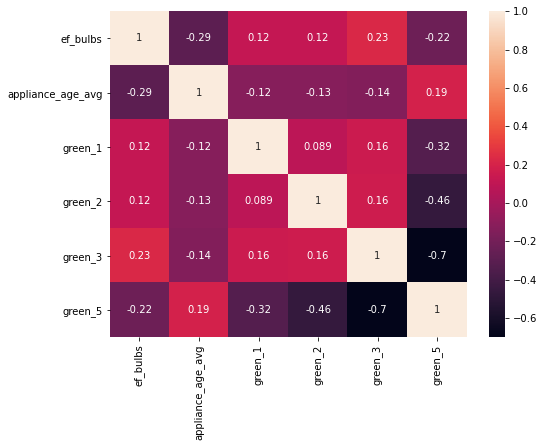

In [158]:
tech = data_main[
    ["ef_bulbs", "appliance_age_avg", "green_1", "green_2", "green_3", "green_5"]
]
plt.figure(figsize=(8, 6))
sns.heatmap(tech.corr(), annot=True);

**2) Correlation of energy efficient attitudes**

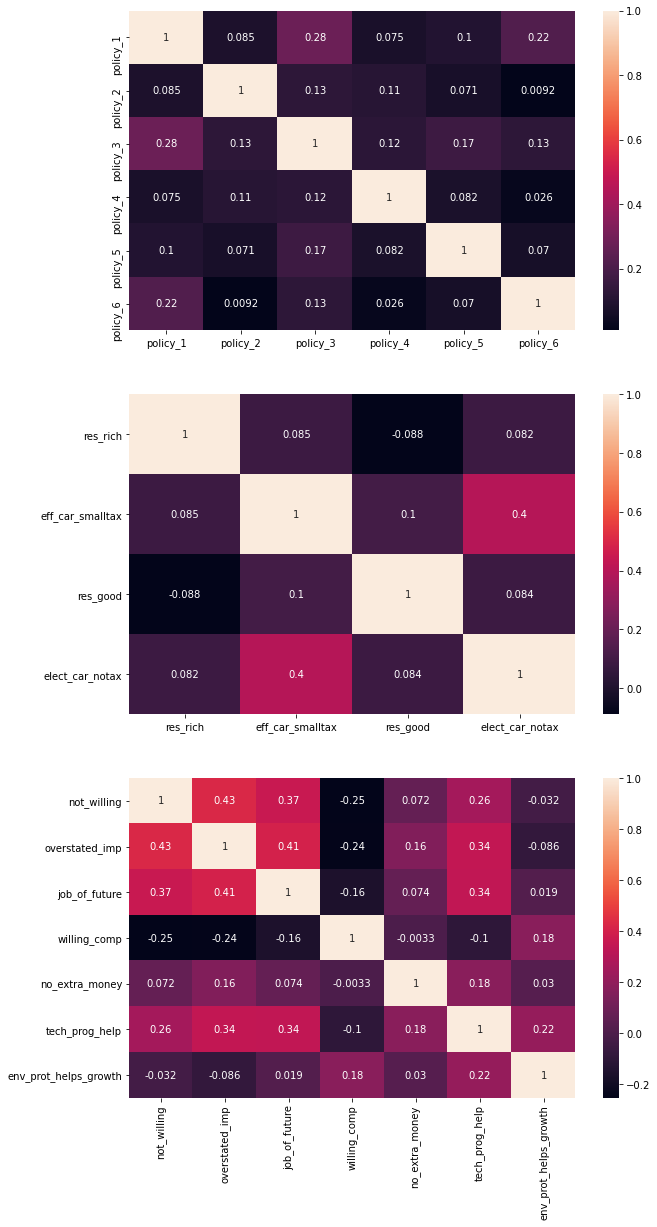

In [160]:
atti = data_main[
    ["policy_1", "policy_2", "policy_3", "policy_4", "policy_5", "policy_6"]
]
fig, axs = plt.subplots(3, 1, figsize=(10, 20))
sns.heatmap(atti.corr(), annot=True, ax=axs[0])

atti2 = data_main[
    [
        "not_willing",
        "overstated_imp",
        "job_of_future",
        "willing_comp",
        "no_extra_money",
        "tech_prog_help",
        "env_prot_helps_growth",
    ]
]
sns.heatmap(atti2.corr(), annot=True, ax=axs[2])

atti3 = data_main[["res_rich", "eff_car_smalltax", "res_good", "elect_car_notax"]]
sns.heatmap(atti3.corr(), annot=True, ax=axs[1]);

**4) Correlation with efficiency measures**

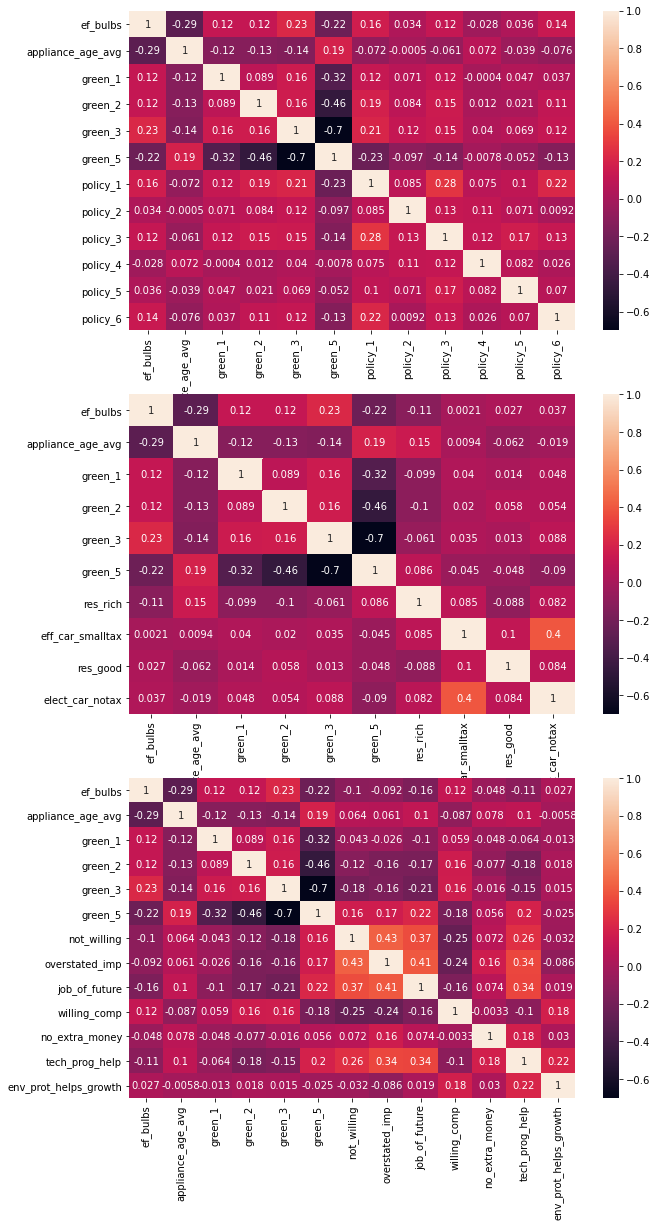

In [161]:
eff_pol = data_main[
    [
        "ef_bulbs",
        "appliance_age_avg",
        "green_1",
        "green_2",
        "green_3",
        "green_5",
        "policy_1",
        "policy_2",
        "policy_3",
        "policy_4",
        "policy_5",
        "policy_6",
    ]
]
fig, axs = plt.subplots(3, 1, figsize=(10, 20))
sns.heatmap(eff_pol.corr(), annot=True, ax=axs[0])

eff_pol = data_main[
    [
        "ef_bulbs",
        "appliance_age_avg",
        "green_1",
        "green_2",
        "green_3",
        "green_5",
        "res_rich",
        "eff_car_smalltax",
        "res_good",
        "elect_car_notax",
    ]
]
sns.heatmap(eff_pol.corr(), annot=True, ax=axs[1])

eff_pol = data_main[
    [
        "ef_bulbs",
        "appliance_age_avg",
        "green_1",
        "green_2",
        "green_3",
        "green_5",
        "not_willing",
        "overstated_imp",
        "job_of_future",
        "willing_comp",
        "no_extra_money",
        "tech_prog_help",
        "env_prot_helps_growth",
    ]
]
sns.heatmap(eff_pol.corr(), annot=True, ax=axs[2]);

### Cronbach Alpha for Likert variables


**Cronbach alpha test on independent variables to be merged**

In [162]:
def attitude_reverse(df1):
    
    if df1 == 'Strongly agree':
        return 1
    elif df1 == 'Agree':
        return 2
    elif df1 == 'Disagree':
        return 3
    elif df1 == 'Strongly disagree':
        return 4
    elif pd.isnull(df1):
        return np.nan


attitude_list = ['not_willing_reverse', 'overstated_imp_reverse', 'job_of_future_reverse', 'willing_comp_reverse', 
                 'no_extra_money_reverse', 'tech_prog_help_reverse', 'env_prot_helps_growth_reverse']
att_list = ['H15A','H15B','H15C','H15D','H15E','H15F','H15G']


for a,b in zip(attitude_list, att_list):
    data_main[a] =  data_main[b].apply(attitude_reverse)
    
data_main[['not_willing_reverse', 'overstated_imp_reverse', 'job_of_future_reverse', 'willing_comp_reverse', 
                 'no_extra_money_reverse', 'tech_prog_help_reverse', 'env_prot_helps_growth_reverse']] = data_main[['not_willing_reverse', 'overstated_imp_reverse', 'job_of_future_reverse', 'willing_comp_reverse', 
                                                                                                                    'no_extra_money_reverse', 'tech_prog_help_reverse', 'env_prot_helps_growth_reverse']].astype('float')

In [163]:
def attitude_reverse_binary(df1):
    
    if df1 == 'Strongly agree':
        return 0
    elif df1 == 'Agree':
        return 0
    elif df1 == 'Disagree':
        return 1
    elif df1 == 'Strongly disagree':
        return 1
    elif pd.isnull(df1):
        return np.nan


attitude_list = ['not_willing_revbi', 'overstated_imp_revbi', 'job_of_future_revbi', 'willing_comp_revbi', 
                 'no_extra_money_revbi', 'tech_prog_help_revbi', 'env_prot_helps_growth_revbi']
att_list = ['H15A','H15B','H15C','H15D','H15E','H15F','H15G']


for a,b in zip(attitude_list, att_list):
    data_main[a] =  data_main[b].apply(attitude_reverse_binary)
    
data_main[['not_willing_revbi', 'overstated_imp_revbi', 'job_of_future_revbi', 'willing_comp_revbi', 
                 'no_extra_money_revbi', 'tech_prog_help_revbi', 'env_prot_helps_growth_revbi']] = data_main[['not_willing_revbi', 'overstated_imp_revbi', 'job_of_future_revbi', 'willing_comp_revbi', 
                                                                                                              'no_extra_money_revbi', 'tech_prog_help_revbi', 'env_prot_helps_growth_revbi']].astype('float')

In [164]:
def CronbachAlpha(itemscores):
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.T.var(axis=1)
    tscores = itemscores.sum(axis=1)
    nitems = len(itemscores[0])
    tscorevar = tscores.var()

    return round(nitems / (nitems-1) * (1 - itemvars.sum() / tscores.var()), 3)

In [165]:
alpha_indep = CronbachAlpha(
    data_main[
        [
            "not_willing_reverse",
            "overstated_imp_reverse",
            "tech_prog_help_reverse",
            "job_of_future_reverse",
        ]
    ].dropna()
)
alpha_indep

0.696

### Independent variable =  Standardizing Likert variables 

In [166]:
sns.set_style("whitegrid")

**Following Bloom et al. 2014 standardization method**

In [167]:
data_main["attitude"] = (
    data_main["not_willing_reverse"]
    + data_main["overstated_imp_reverse"]
    + data_main["tech_prog_help_reverse"]
    + data_main["job_of_future_reverse"]
) / 4

In [168]:
data_main["att_std"] = np.nan

for row in range(len(data_main)):
    data_main["att_std"].iloc[row] = (
        (
            (
                data_main["not_willing_reverse"].iloc[row]
                - data_main["not_willing_reverse"].mean()
            )
            / data_main["not_willing_reverse"].std()
        )
        + (
            (
                data_main["overstated_imp_reverse"].iloc[row]
                - data_main["overstated_imp_reverse"].mean()
            )
            / data_main["overstated_imp_reverse"].std()
        )
        + (
            (
                data_main["tech_prog_help_reverse"].iloc[row]
                - data_main["tech_prog_help_reverse"].mean()
            )
            / data_main["tech_prog_help_reverse"].std()
        )
        + (
            (
                data_main["job_of_future_reverse"].iloc[row]
                - data_main["job_of_future_reverse"].mean()
            )
            / data_main["job_of_future_reverse"].std()
        )
    ) / 4

data_main["att_2std"] = np.nan
for row in range(len(data_main)):
    data_main["att_2std"].iloc[row] = (
        data_main["att_std"].iloc[row] - data_main["att_std"].mean()
    ) / data_main["att_std"].std()

C:\Users\T440s\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


**Dealing with NA values for important variables**

In [169]:
data_main = data_main[data_main['resp_age'] >= 30]

In [170]:
def impute_missing(var):
    data_main[var].fillna(data_main[var].median(), inplace = True)
    
variables = [
        "rural",
        "gender",
        "resp_age",
        "detached",
        "children",
        "elderly",
        "subsidy",
        "semi_detached"]

for var in variables:
    impute_missing(var)
    
data_main['income_decile'] = np.where(data_main['income_decile'].isna(), "Lower middle income", data_main['income_decile'])
data_main.dropna(subset = ['S3', 'Country', 'att_2std', 'ef_bulbs', 'green_3', 'green_2'], inplace = True)

In [171]:
countries = (
    data_main.groupby("Country")["Country"]
    .count()
    .reset_index(name="Count")
    .sort_values(by="Count")
)

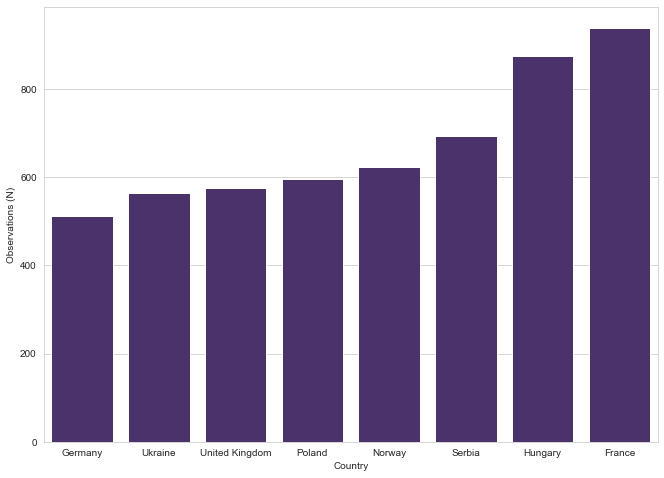

In [60]:
sns.set_palette("viridis")
plt.figure(figsize = (11,8))
sns.barplot(
   x = "Country", y = "Count", data=countries, color = "#4B2974"
)
plt.ylabel('Observations (N)')
plt.savefig("results/country_obs.png")

In [172]:
def sample_table(data, indi, names):
    table = pd.DataFrame()
    for i,n in zip(indi, names):
        sub_table = data.groupby(i)[i].count().reset_index(name='Number')
        sub_table.rename(columns = {i: "Item"}, inplace = True)
        sub_table["Percentage (%)"] = np.nan
        for i in range(len(sub_table)):
            sub_table["Percentage (%)"].iloc[i] = round(sub_table["Number"].iloc[i]/sub_table["Number"].sum()*100)
        name_list = [n]*len(sub_table)
        sub_table.index = name_list
        table = table.append(sub_table)
    return table

table_des = sample_table(data_main, ['S5', "resp_age_bins", "S2", 'income_decile', "S3", "Country", "S6", "H1"], ['Gender', "Age", "Education level", "Income quantile", "Employment status", "Country", "Region", "Home type"])
table_des.to_excel("results/descriptives.xlsx")

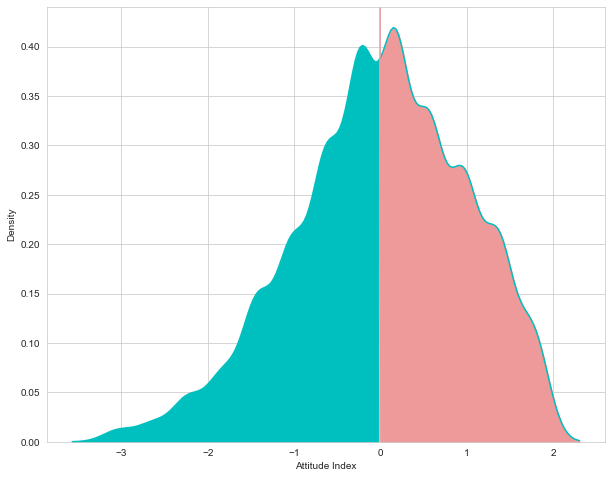

In [186]:
plt.figure(figsize = (10,8))
ax =  sns.kdeplot(data_main['att_2std'].dropna(), color="c")
plt.xlabel("Attitude Index")
kde_x, kde_y = ax.lines[0].get_data()
p1 = plt.axvline(x=0,color='#EF9A9A')
ax.fill_between(kde_x, kde_y, where=(kde_x>0) ,interpolate=True, color='#EF9A9A')
ax.fill_between(kde_x, kde_y, where=(kde_x<0) ,interpolate=True, color='c')

plt.savefig('results/attindexdist.png')

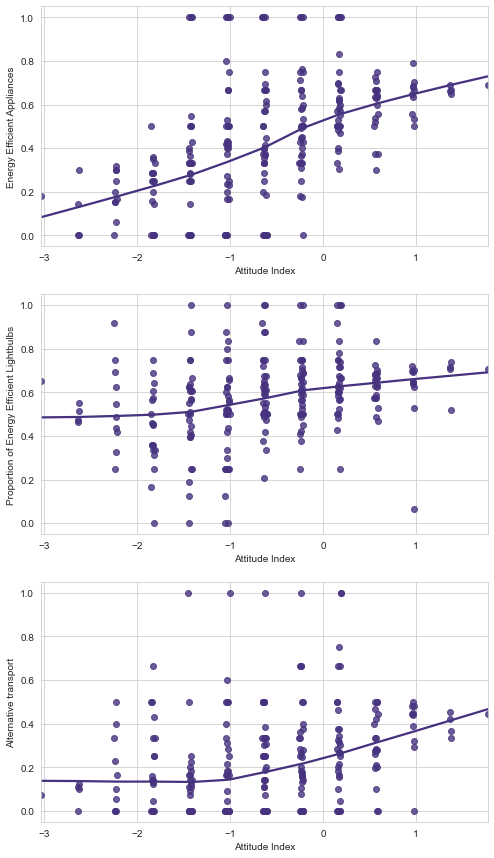

In [187]:
attitude1 = (
    data_main.groupby("att_2std")["green_3"].agg([np.mean, np.std]).reset_index()
)
attitude2 = (
    data_main.groupby("att_2std")["ef_bulbs"].agg([np.mean, np.std]).reset_index()
)
attitude3 = (
    data_main.groupby("att_2std")["green_2"].agg([np.mean, np.std]).reset_index()
)
attitude4 = (
    data_main.groupby("att_2std")["green_1"].agg([np.mean, np.std]).reset_index()
)

sns.set_palette("viridis")
fig, axes = plt.subplots(3, 1, figsize=(8, 15))
for att, r, name in zip(
    [attitude1, attitude2, attitude3, attitude4],
    [0, 1, 2],
    [
        "Energy Efficient Appliances",
        "Proportion of Energy Efficient Lightbulbs",
        "Alternative transport",
        "Efficient car",
    ],
):
    sns.regplot(x="att_2std", y="mean", data=att, lowess=True,ci="sd", ax=axes[r])
    axes[r].set_xlabel("Attitude Index")
    axes[r].set_ylabel(name)

plt.savefig('results/depindep.png')

In [188]:
country_nums = data_main.groupby("Country").agg({"Country": "count"})
country_nums.index = country_nums.index.set_names(["name"])
country_nums.reset_index(inplace=True)

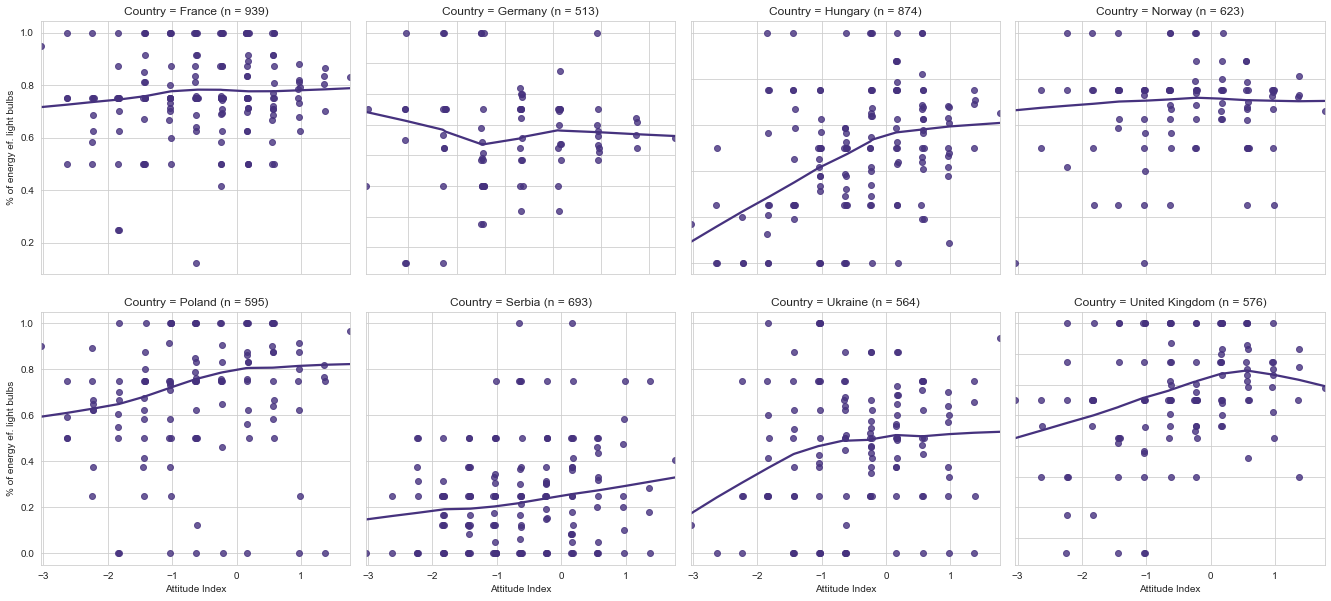

In [189]:
sns.set_palette("viridis")
fig, axes = plt.subplots(2, 4, figsize=(23, 10))
for r, d, c, b in zip(
    [0, 0, 0, 0, 1, 1, 1, 1],
    [0, 1, 2, 3, 0, 1, 2, 3],
    country_nums.name,
    country_nums.Country,
):
    att = (
        data_main[data_main["Country"] == c]
        .groupby(["att_2std"])["ef_bulbs"]
        .agg([np.mean])
        .reset_index()
    )
    sns.regplot(x="att_2std", y="mean", data=att, ax=axes[r, d], lowess=True)
    axes[r, d].set_title("Country = {} (n = {})".format(c, b))
    axes[r, d].set_ylabel("% of energy ef. light bulbs")
    if (r == 1) & (d != 0):
        axes[r, d].set_xlabel("Attitude Index")
        axes[r, d].set_ylabel("")
        axes[r, d].set_yticklabels([])
    elif (r == 1) & (d == 0):
        axes[r, d].set_xlabel("Attitude Index")
    elif (r == 0) & (d != 0):
        axes[r, d].set_ylabel("")
        axes[r, d].set_yticklabels([])
        axes[r, d].set_xlabel("")
        axes[r, d].set_xticklabels([])
    elif (r == 0) & (d == 0):
        axes[r, d].set_xlabel("")
        axes[r, d].set_xticklabels([])

plt.subplots_adjust(wspace=0.05, hspace=0.15)
plt.savefig('results/dep1indep.png')

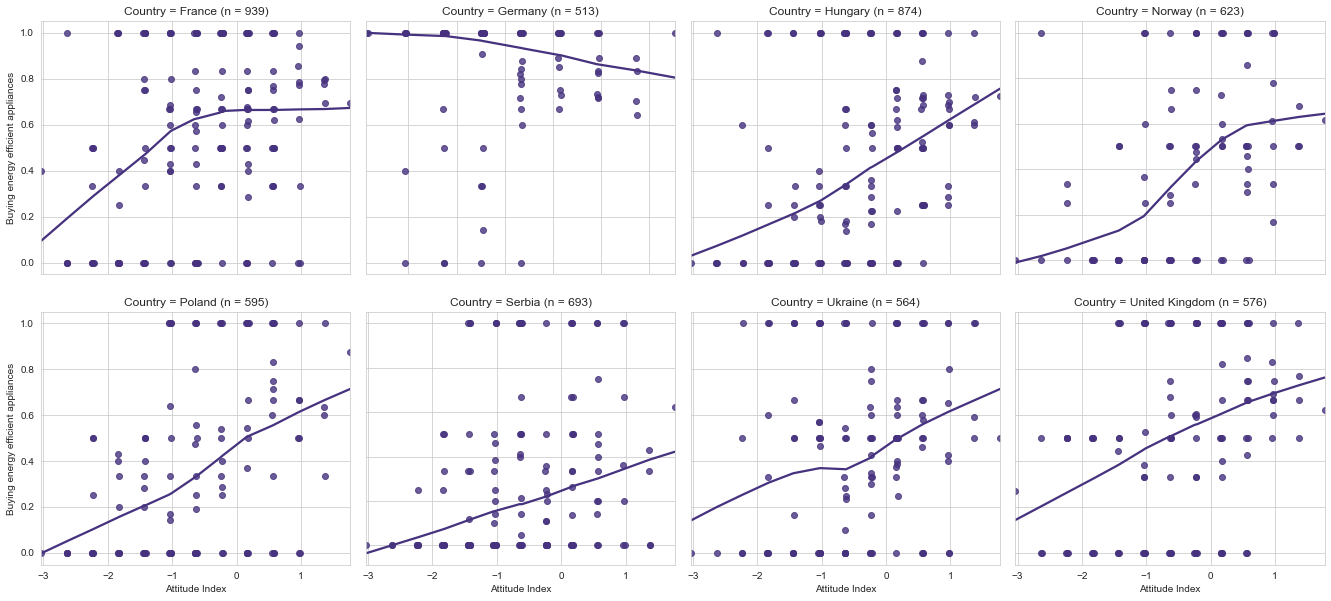

In [190]:
sns.set_palette("viridis")
fig, axes = plt.subplots(2, 4, figsize=(23, 10))
for r, d, c, b in zip(
    [0, 0, 0, 0, 1, 1, 1, 1],
    [0, 1, 2, 3, 0, 1, 2, 3],
    country_nums.name,
    country_nums.Country,
):
    att = (
        data_main[data_main["Country"] == c]
        .groupby(["att_2std"])["green_3"]
        .agg([np.mean])
        .reset_index()
    )
    sns.regplot(x="att_2std", y="mean", data=att, ax=axes[r, d], lowess=True)
    axes[r, d].set_title("Country = {} (n = {})".format(c, b))
    axes[r, d].set_ylabel("Buying energy efficient appliances")
    if (r == 1) & (d != 0):
        axes[r, d].set_xlabel("Attitude Index")
        axes[r, d].set_ylabel("")
        axes[r, d].set_yticklabels([])
    elif (r == 1) & (d == 0):
        axes[r, d].set_xlabel("Attitude Index")
    elif (r == 0) & (d != 0):
        axes[r, d].set_ylabel("")
        axes[r, d].set_yticklabels([])
        axes[r, d].set_xlabel("")
        axes[r, d].set_xticklabels([])
    elif (r == 0) & (d == 0):
        axes[r, d].set_xlabel("")
        axes[r, d].set_xticklabels([])

plt.subplots_adjust(wspace=0.05, hspace=0.15)
plt.savefig('results/dep2indep.png')

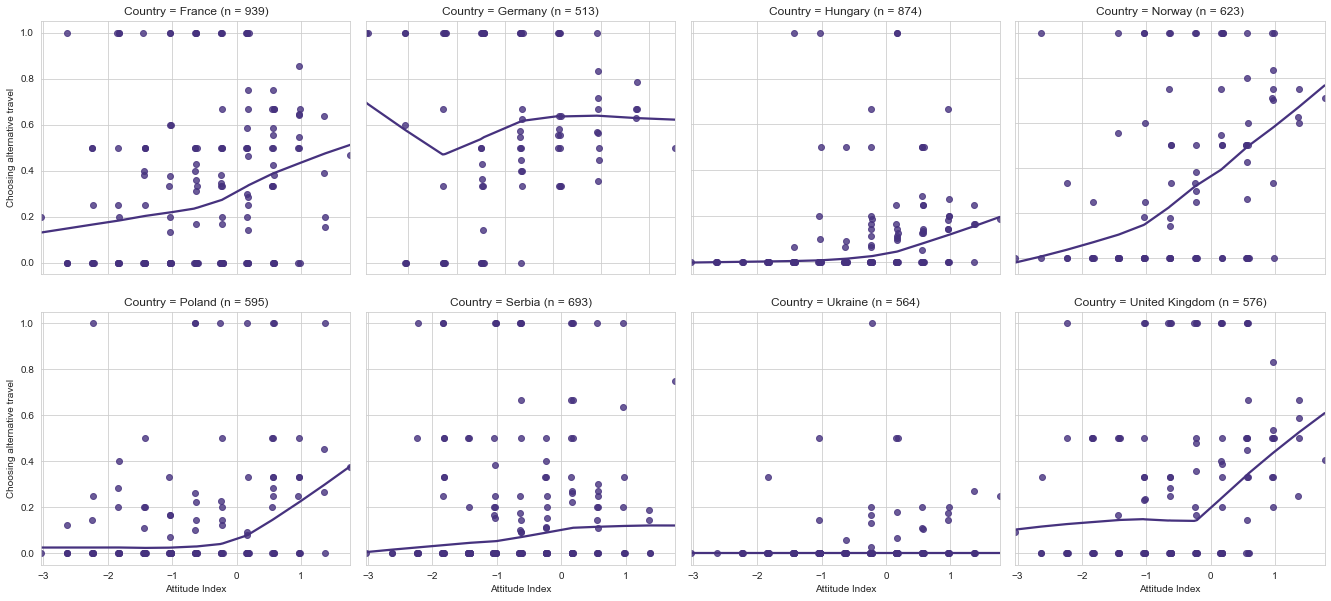

In [191]:
sns.set_palette("viridis")
fig, axes = plt.subplots(2, 4, figsize=(23, 10))
for r, d, c, b in zip(
    [0, 0, 0, 0, 1, 1, 1, 1],
    [0, 1, 2, 3, 0, 1, 2, 3],
    country_nums.name,
    country_nums.Country,
):
    att = (
        data_main[data_main["Country"] == c]
        .groupby(["att_2std"])["green_2"]
        .agg([np.mean])
        .reset_index()
    )
    sns.regplot(x="att_2std", y="mean", data=att, ax=axes[r, d], lowess=True)
    axes[r, d].set_title("Country = {} (n = {})".format(c, b))
    axes[r, d].set_ylabel("Choosing alternative travel")
    if (r == 1) & (d != 0):
        axes[r, d].set_xlabel("Attitude Index")
        axes[r, d].set_ylabel("")
        axes[r, d].set_yticklabels([])
    elif (r == 1) & (d == 0):
        axes[r, d].set_xlabel("Attitude Index")
    elif (r == 0) & (d != 0):
        axes[r, d].set_ylabel("")
        axes[r, d].set_yticklabels([])
        axes[r, d].set_xlabel("")
        axes[r, d].set_xticklabels([])
    elif (r == 0) & (d == 0):
        axes[r, d].set_xlabel("")
        axes[r, d].set_xticklabels([])

plt.subplots_adjust(wspace=0.05, hspace=0.15)
plt.savefig('results/dep3indep.png')

<Figure size 1152x720 with 0 Axes>

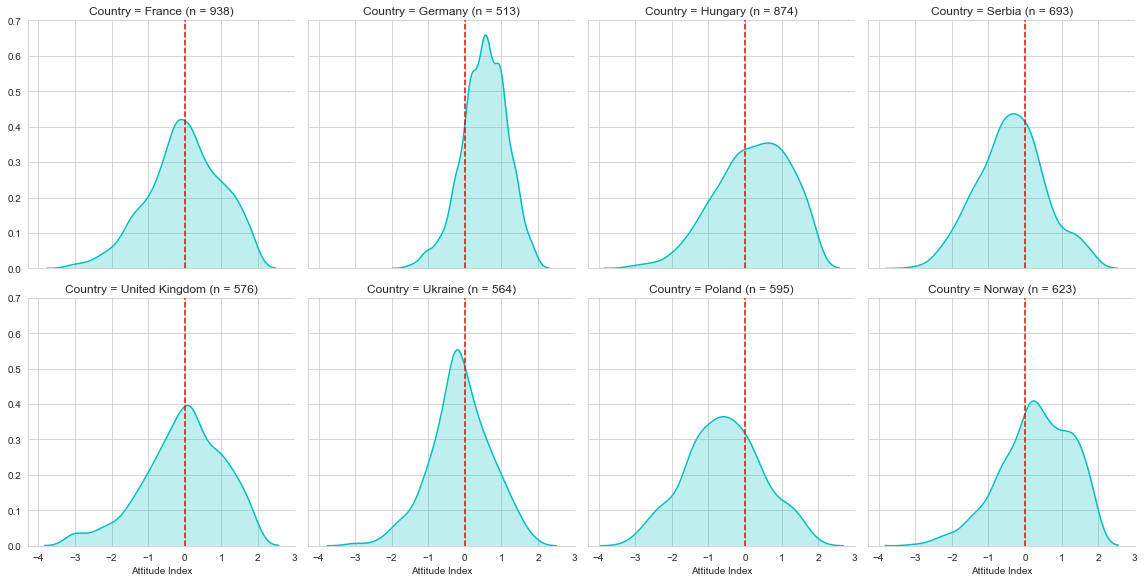

In [68]:
plt.figure(figsize=(16, 10))
bins = 12
g = sns.FacetGrid(data_main, col="Country", col_wrap=4, height=4)
g = g.map(
    sns.distplot,
    "att_2std",
    bins=bins,
    color="c",
    hist=False,
    kde_kws={"shade": True}
)

g.map(plt.axvline, x=0, ls='--', c='red')
        
g.set(ylim=(0, 0.7))

g.axes[0].set_title("Country = France (n = 938)")
g.axes[1].set_title("Country = Germany (n = 513)")
g.axes[2].set_title("Country = Hungary (n = 874)")
g.axes[3].set_title("Country = Serbia (n = 693)")
g.axes[4].set_title("Country = United Kingdom (n = 576)")
g.axes[5].set_title("Country = Ukraine (n = 564)")
g.axes[6].set_title("Country = Poland (n = 595)")
g.axes[7].set_title("Country = Norway (n = 623)")
g.set_xlabels("Attitude Index")
plt.savefig('results/attindexdistcountry.png')

In [69]:
data_poor = data_main[
    (data_main["income_decile"] == "Poor")
    | (data_main["income_decile"] == "Low income")
]
data_rich = data_main[
    (data_main["income_decile"] == "High income")
    | (data_main["income_decile"] == "Upper middle income")
]

km_test_inc = stats.ks_2samp(
    data_poor["att_2std"].dropna(), data_rich["att_2std"].dropna()
)

data_noedu = data_main[
    (data_main["education"] == 0)
    | (data_main["education"] == 1)
    | (data_main["education"] == 2)
]
data_edu = data_main[(data_main["education"] == 3) | (data_main["education"] == 4)]

km_test_edu = stats.ks_2samp(
    data_noedu["att_2std"].dropna(), data_edu["att_2std"].dropna()
)

data_young = data_main[data_main["resp_age"] <= 48]
data_old = data_main[data_main["resp_age"] > 48]

km_test_age = stats.ks_2samp(
    data_young["att_2std"].dropna(), data_old["att_2std"].dropna()
)

data_male = data_main[data_main["gender"] == 0]
data_female = data_main[data_main["gender"] == 1]

km_test_gender = stats.ks_2samp(
    data_male["att_2std"].dropna(), data_female["att_2std"].dropna()
)

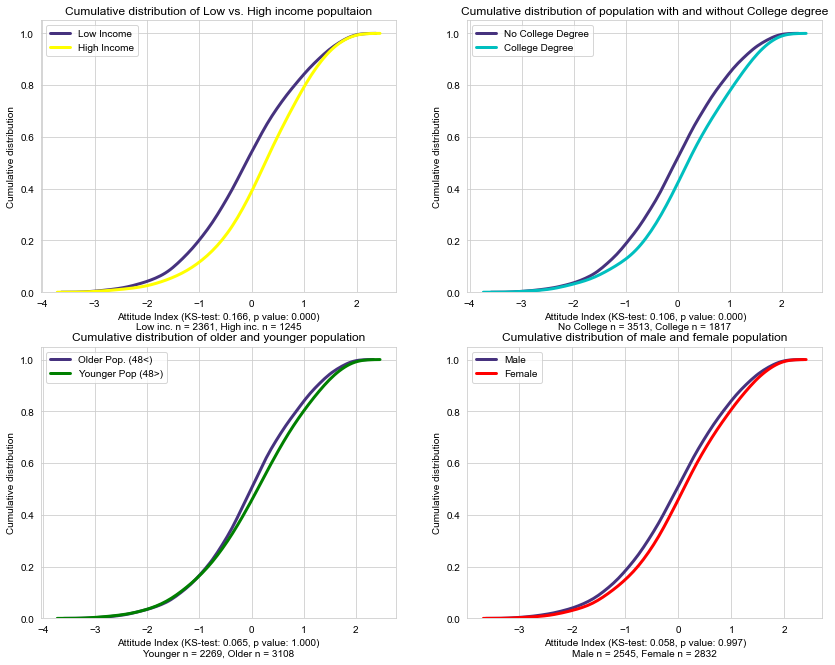

In [93]:
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

sns.distplot(
    data_poor["att_2std"].dropna(),
    hist=False,
    kde_kws={"cumulative": True, "linewidth": 3},
    ax=axes[0,0],
    label = 'Low Income'
)
sns.distplot(
    data_rich["att_2std"].dropna(),
    hist=False,
    kde_kws={"cumulative": True, "linewidth": 3},
    ax=axes[0,0],
    color="yellow",
    label= 'High Income'
)

axes[0,0].set_xlabel(
    "Attitude Index (KS-test: {:.3f}, p value: {:.3f})\nLow inc. n = {}, High inc. n = {}".format(
        km_test_inc[0], km_test_inc[1], len(data_poor), len(data_rich)
    )
)
axes[0,0].set_ylabel("Cumulative distribution")

axes[0,0].set_title("Cumulative distribution of Low vs. High income popultaion")


axes[0,0].legend(loc="upper left")

#########################

sns.distplot(
    data_noedu["att_2std"].dropna(),
    hist=False,
    kde_kws={"cumulative": True, "linewidth": 3},
    ax=axes[0,1],
    label = 'No College Degree'
)
sns.distplot(
    data_edu["att_2std"].dropna(),
    hist=False,
    kde_kws={"cumulative": True, "linewidth": 3},
    ax=axes[0,1],
    color="c",
    label = 'College Degree'
)

axes[0,1].set_xlabel(
    "Attitude Index (KS-test: {:.3f}, p value: {:.3f})\nNo College n = {}, College n = {}".format(
        km_test_edu[0], km_test_edu[1], len(data_noedu), len(data_edu)
    )
)
axes[0,1].set_ylabel("Cumulative distribution")

axes[0,1].set_title("Cumulative distribution of population with and without College degree")
axes[0,1].legend(loc="upper left")

#########################

sns.distplot(
    data_old["att_2std"].dropna(),
    hist=False,
    kde_kws={"cumulative": True, "linewidth": 3},
    ax=axes[1,0],
    label = 'Older Pop. (48<)'
)
sns.distplot(
    data_young["att_2std"].dropna(),
    hist=False,
    kde_kws={"cumulative": True, "linewidth": 3},
    ax=axes[1,0],
    color="g",
    label = 'Younger Pop (48>)'
)

axes[1,0].set_xlabel(
    "Attitude Index (KS-test: {:.3f}, p value: {:.3f})\nYounger n = {}, Older n = {}".format(
        km_test_age[0], km_test_age[1], len(data_young), len(data_old)
    )
)
axes[1,0].set_ylabel("Cumulative distribution")

axes[1,0].set_title("Cumulative distribution of older and younger population")
axes[1,0].legend(loc="upper left")

#########################

sns.distplot(
    data_male["att_2std"].dropna(),
    hist=False,
    kde_kws={"cumulative": True, "linewidth": 3},
    ax=axes[1,1],
    label = 'Male'
)
sns.distplot(
    data_female["att_2std"].dropna(),
    hist=False,
    kde_kws={"cumulative": True, "linewidth": 3},
    ax=axes[1,1],
    color="r",
    label = 'Female'
)

axes[1,1].set_xlabel(
    "Attitude Index (KS-test: {:.3f}, p value: {:.3f})\nMale n = {}, Female n = {}".format(
        km_test_gender[0], km_test_gender[1], len(data_male), len(data_female)
    )
)
axes[1,1].set_ylabel("Cumulative distribution")

axes[1,1].set_title("Cumulative distribution of male and female population")
axes[1,1].legend(loc="upper left")

plt.savefig('results/attindexcovar.png')

### Dependent variable

**Cronbach alpha test on dependent variables to be merged**

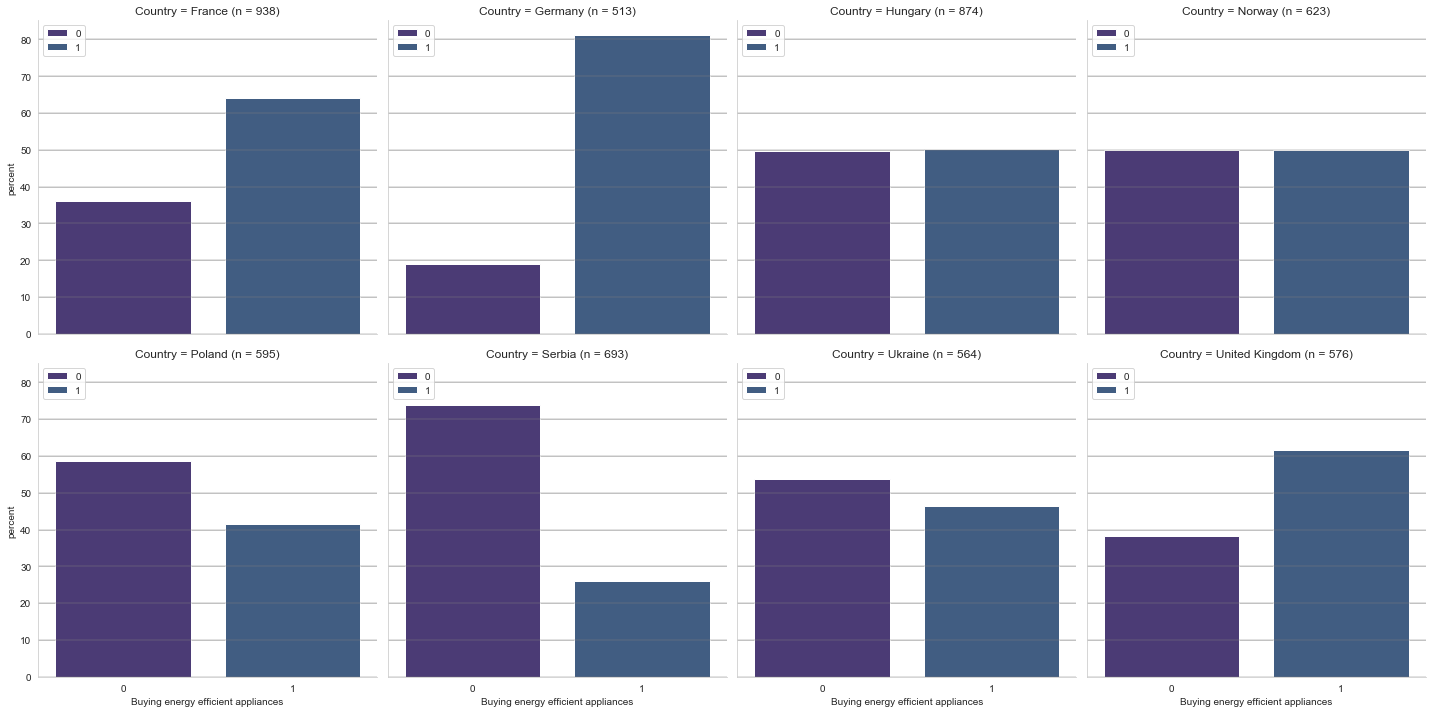

In [71]:
g_green3 = data_main.groupby("Country")["green_3"].value_counts(normalize=True)
g_green3 = g_green3.mul(100)
g_green3 = g_green3.rename("percent").reset_index()


g = sns.catplot(
    x="green_3", y="percent", col="Country", col_wrap=4, data=g_green3, kind="bar", hue="green_3",dodge=False
)

#plt.figure(figsize = (25,15))

#g.add_legend()
for a in g.axes:
    for gri in range(9):
        a.axhline(a.get_yticks()[gri], alpha=0.3, color="grey")
    a.legend(loc="upper left")

g.axes[0].set_title("Country = France (n = 938)")
g.axes[1].set_title("Country = Germany (n = 513)")
g.axes[2].set_title("Country = Hungary (n = 874)")
g.axes[3].set_title("Country = Norway (n = 623)")
g.axes[4].set_title("Country = Poland (n = 595)")
g.axes[5].set_title("Country = Serbia (n = 693)")
g.axes[6].set_title("Country = Ukraine (n = 564)")
g.axes[7].set_title("Country = United Kingdom (n = 576)")

g.set_xlabels("Buying energy efficient appliances")
plt.savefig('results/dep1country.png')

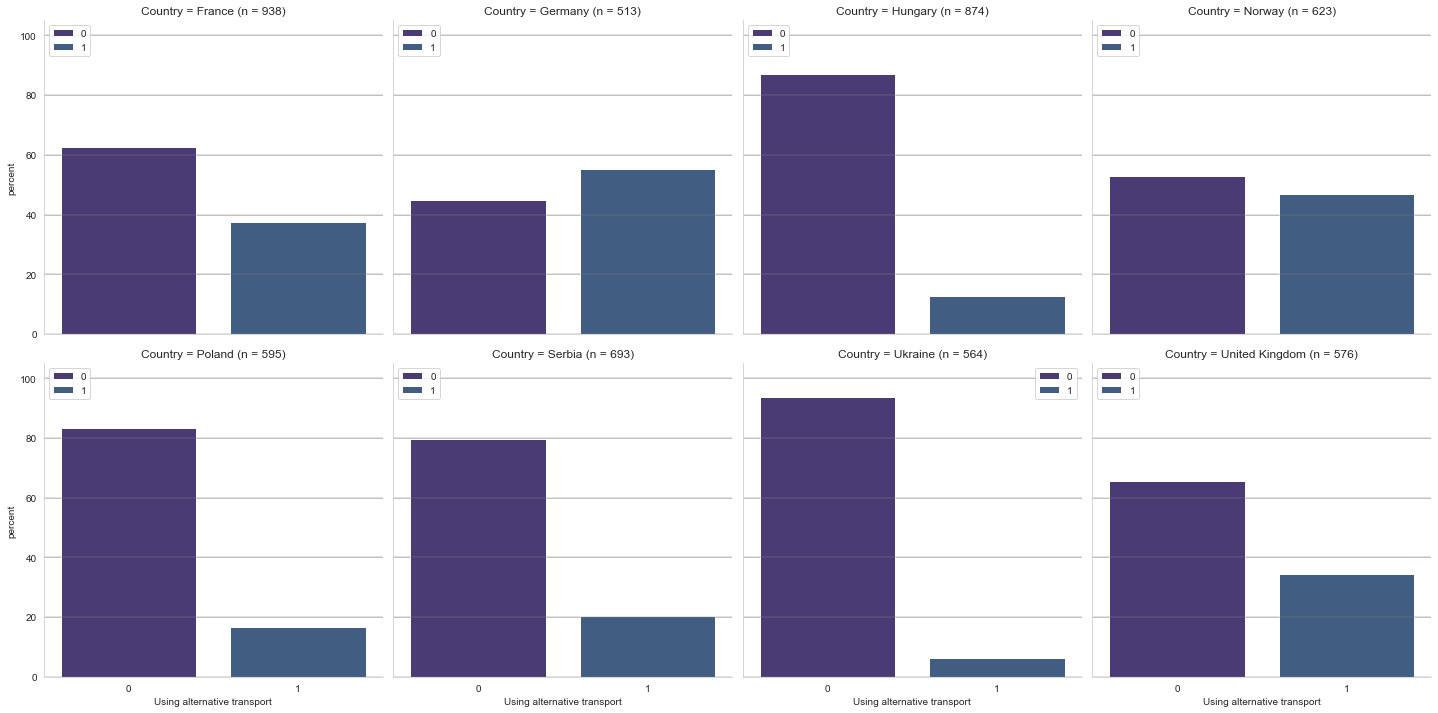

In [72]:
g_green2 = data_main.groupby("Country")["green_2"].value_counts(normalize=True)
g_green2 = g_green2.mul(100)
g_green2 = g_green2.rename("percent").reset_index()

g = sns.catplot(
    x="green_2", y="percent", col="Country", col_wrap=4, data=g_green2, kind="bar", hue="green_2", dodge = False
)

b = 0
for a in g.axes:

    for gri in range(6):
        a.axhline(a.get_yticks()[gri], alpha=0.3, color="grey")
    a.legend(loc="upper left")
    if b == 6:
        a.legend(loc="upper right")
    b+=1
        

g.axes[0].set_title("Country = France (n = 938)")
g.axes[1].set_title("Country = Germany (n = 513)")
g.axes[2].set_title("Country = Hungary (n = 874)")
g.axes[3].set_title("Country = Norway (n = 623)")
g.axes[4].set_title("Country = Poland (n = 595)")
g.axes[5].set_title("Country = Serbia (n = 693)")
g.axes[6].set_title("Country = Ukraine (n = 564)")
g.axes[7].set_title("Country = United Kingdom (n = 576)")

#g = sns.FacetGrid(tips, col="time",  hue="smoker")
g.set_xlabels("Using alternative transport")
plt.savefig('results/dep2country.png')

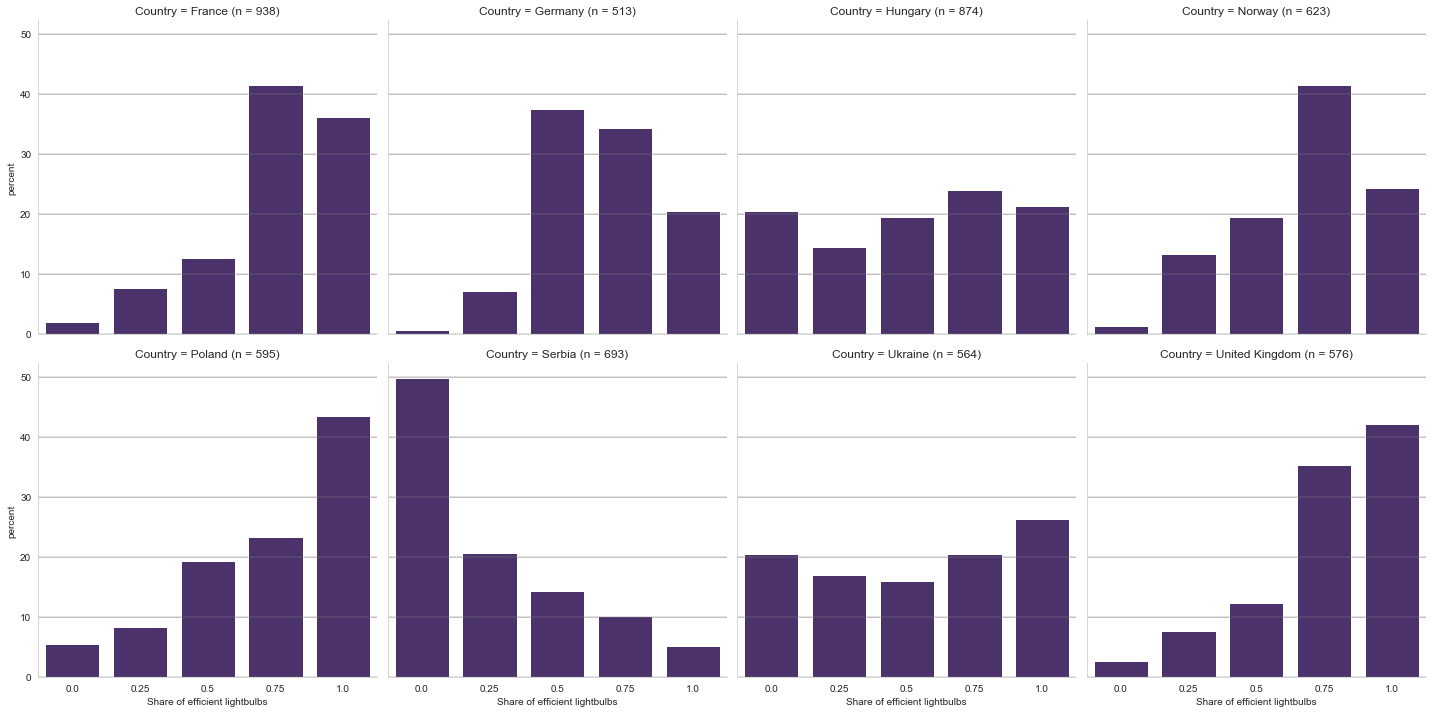

In [74]:
g_ef = data_main.groupby("Country")["ef_bulbs"].value_counts(normalize=True)
g_ef = g_ef.mul(100)
g_ef = g_ef.rename("percent").reset_index()

g = sns.catplot(
    x="ef_bulbs", y="percent", col="Country", col_wrap=4, color = "#4B2974", data=g_ef, kind="bar"
)

for a in g.axes:
    for gri in range(6):
        a.axhline(a.get_yticks()[gri], alpha=0.3, color="grey")

g.axes[0].set_title("Country = France (n = 938)")
g.axes[1].set_title("Country = Germany (n = 513)")
g.axes[2].set_title("Country = Hungary (n = 874)")
g.axes[3].set_title("Country = Norway (n = 623)")
g.axes[4].set_title("Country = Poland (n = 595)")
g.axes[5].set_title("Country = Serbia (n = 693)")
g.axes[6].set_title("Country = Ukraine (n = 564)")
g.axes[7].set_title("Country = United Kingdom (n = 576)")

g.set_xlabels("Share of efficient lightbulbs")
plt.savefig('results/dep3country.png')

In [75]:
data_main["ef_bulbs_bin"] = np.where(data_main["ef_bulbs"] <= 0.5, 0, 1)
data_main["education_bin"] = np.where(data_main["education"] <= 2, 0, 1)
data_main.loc[data_main["education"].isna(), "education_bin"] = np.nan

pd.set_option("display.precision", 3)


def t_table01(data, var, indi):
    df_all = pd.DataFrame()
    t_s = []
    p_s = []
    diffs = []
    for i in indi:
        df = data.groupby(var)[i].agg(np.mean).T
        diffs.append(df[0] - df[1])
        t, p = ttest_ind(
            data[data[var] == 0][i], data[data[var] == 1][i], nan_policy="omit"
        )
        t_s.append(t)
        p_s.append("{:,.3f}".format(p))
        df_all = df_all.append(df)

    df_all["difference"] = diffs
    df_all["p value"] = p_s

    return df_all


t_tests = pd.DataFrame()
df = {}
dependents = ["green_2", "green_3", "ef_bulbs_bin"]
dep_names = [
    "Using alternative transport",
    "Buying efficient appliances",
    "Share of ef. bulbs (50% cut-off)",
]
for dep, i in zip(dependents, dep_names):
    df[i] = t_table01(
        data_main[data_main["resp_age"] > 30],
        dep,
        [
            "education_bin",
            "income_dec_num10",
            "gender",
            "resp_age",
            "household_members",
            "children",
            "elderly",
            "house_big",
            "before_1990",
            "appliance_age_avg",
            "rural",
            "detached",
        ],
    )

t_tests = pd.concat([t_tests, pd.concat(df, axis=1)], axis=1)

In [76]:
t_tests

Using alternative transport                             \
                                            0       1 difference p value   
education_bin                           0.297   0.447     -0.150   0.000   
income_dec_num10                        4.463   5.323     -0.860   0.000   
gender                                  0.531   0.507      0.025   0.111   
resp_age                               53.937  52.638      1.299   0.003   
household_members                       2.664   2.689     -0.025   0.575   
children                                0.654   0.724     -0.070   0.018   
elderly                                 0.607   0.621     -0.013   0.570   
house_big                               0.405   0.452     -0.047   0.002   
before_1990                             0.770   0.726      0.044   0.001   
appliance_age_avg                       2.009   1.839      0.170   0.000   
rural                                   0.721   0.567      0.154   0.000   
detached                                0.516   0.395      0.120   0.000   

                  Buying efficient appliances                             \
                                            0       1 difference p value   
education_bin                           0.292   0.381     -0.090   0.000   
income_dec_num10                        4.319   5.047     -0.727   0.000   
gender                                  0.514   0.534     -0.020   0.147   
resp_age                               53.795  53.375      0.420   0.283   
household_members                       2.650   2.689     -0.039   0.341   
children                                0.637   0.707     -0.070   0.008   
elderly                                 0.615   0.607      0.008   0.701   
house_big                               0.379   0.454     -0.075   0.000   
before_1990                             0.781   0.737      0.044   0.000   
appliance_age_avg                       2.074   1.860      0.214   0.000   
rural                                   0.672   0.684     -0.012   0.341   
detached                                0.490   0.475      0.015   0.293   

                  Share of ef. bulbs (50% cut-off)                             
                                                 0       1 difference p value  
education_bin                                0.247   0.409     -0.162   0.000  
income_dec_num10                             4.452   4.893     -0.441   0.000  
gender                                       0.538   0.514      0.024   0.080  
resp_age                                    54.927  52.527      2.401   0.000  
household_members                            2.643   2.692     -0.049   0.227  
children                                     0.539   0.778     -0.239   0.000  
elderly                                      0.570   0.642     -0.072   0.001  
house_big                                    0.376   0.451     -0.075   0.000  
before_1990                                  0.802   0.724      0.078   0.000  
appliance_age_avg                            2.109   1.847      0.262   0.000  
rural                                        0.691   0.669      0.022   0.091  
detached                                     0.523   0.450      0.074   0.000

In [77]:
t_tests.to_excel('results/depvar_ttest.xlsx')

In [192]:
data_main.to_stata("data/main_data.dta")

### Visualisation for Defense

In [79]:
import matplotlib as mpl
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

Text(0.5, 1.0, 'Income group of respondents')

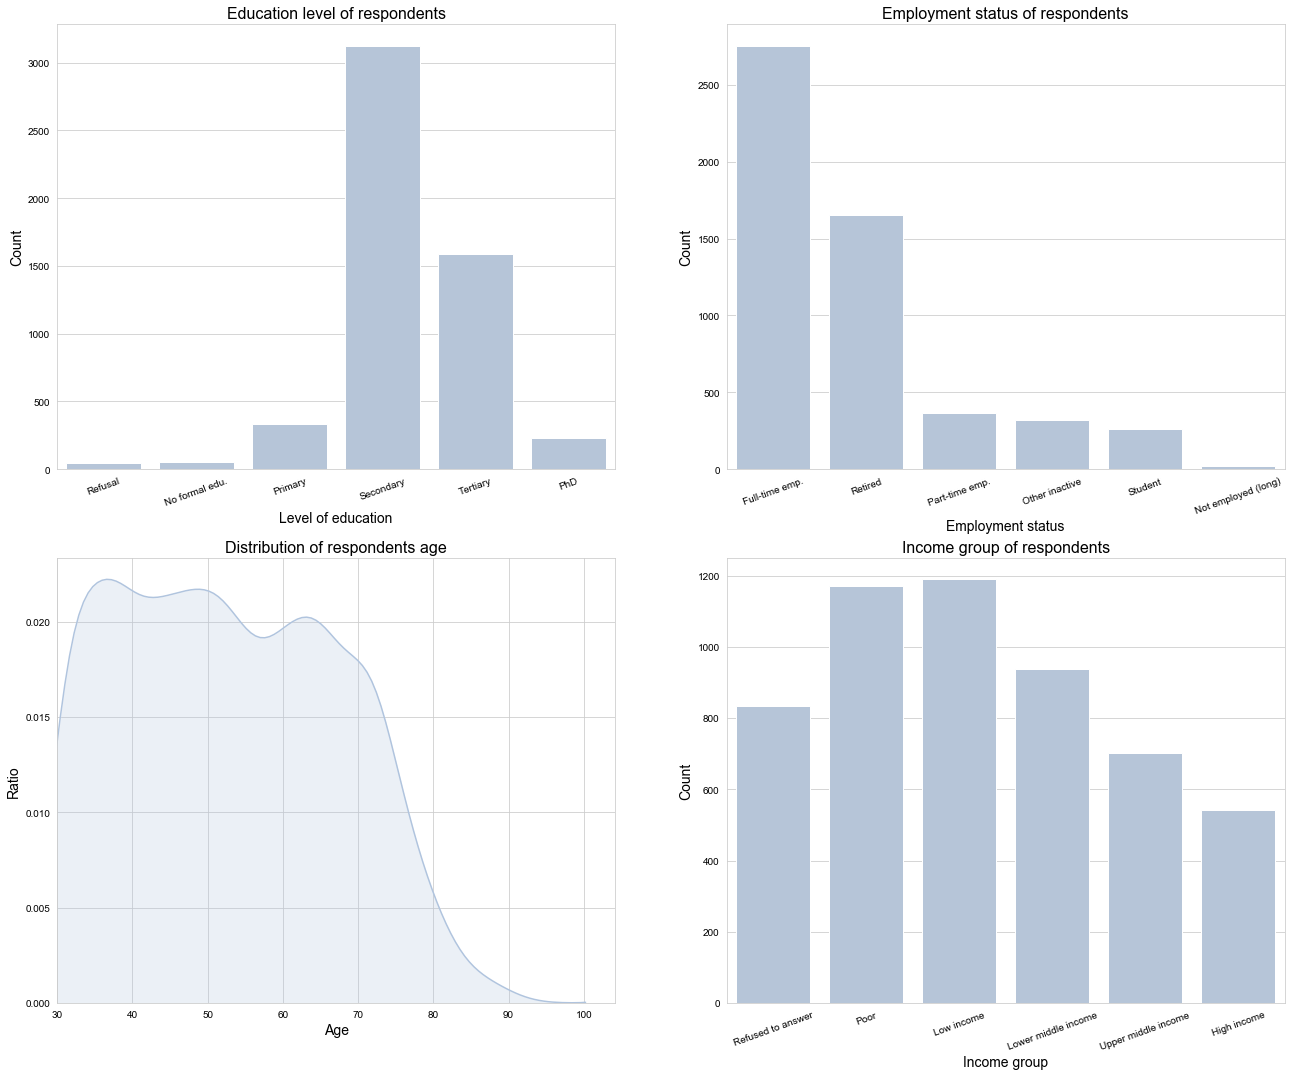

In [80]:
fig, axs = plt.subplots(2, 2, figsize=(22, 18))
sns.countplot(
    x="S2",
    data=data_main,
    order=[
        "Do not know / Refusal",
        "No formal education or below primary",
        "Primary education",
        "Secondary  and post-secondary non-tertiary education",
        "Tertiary education first stage, i.e. bachelor or master",
        "Tertiary education second stage (PhD)",
    ],
    ax=axs[0, 0],
    color="lightsteelblue",
)
axs[0, 0].set_xticklabels(
    ["Refusal", "No formal edu.", "Primary", "Secondary", "Tertiary", "PhD"],
    rotation=20,
)
axs[0, 0].set_ylabel("Count", fontsize = 14)
axs[0, 0].set_xlabel("Level of education", fontsize = 14)
axs[0, 0].set_title("Education level of respondents", fontsize=16)

sns.countplot(
    x="S3",
    data=data_main,
    order=data_main["S3"].value_counts().index,
    ax=axs[0, 1],
    color="lightsteelblue",
)
axs[0, 1].set_xticklabels(
    [
        "Full-time emp.",
        "Retired",
        "Part-time emp.",
        "Other inactive",
        "Student",
        "Not employed (long)",
        "Refuse",
    ],
    rotation=20,
)
axs[0, 1].set_ylabel("Count", fontsize = 14)
axs[0, 1].set_xlabel("Employment status", fontsize = 14)
axs[0, 1].set_title("Employment status of respondents", fontsize=16)

sns.distplot(
    data_main["resp_age"].dropna(),
    ax=axs[1, 0],
    hist=False,
    color="lightsteelblue",
    kde_kws={"shade": True},
)
axs[1, 0].set_xlim(left=30)
axs[1, 0].set_xlabel("Age", fontsize = 14)
axs[1, 0].set_ylabel("Ratio", fontsize = 14)
axs[1, 0].set_title("Distribution of respondents age", fontsize=16)

sns.countplot(
    x="income_decile",
    data=data_main,
    order=[
        "Refused to answer",
        "Poor",
        "Low income",
        "Lower middle income",
        "Upper middle income",
        "High income",
    ],
    color="lightsteelblue",
)
axs[1, 1].set_xticklabels(
    [
        "Refused to answer",
        "Poor",
        "Low income",
        "Lower middle income",
        "Upper middle income",
        "High income",
    ],
    rotation=20,
)
axs[1, 1].set_ylabel("Count", fontsize = 14)
axs[1, 1].set_xlabel("Income group", fontsize = 14)
axs[1, 1].set_title("Income group of respondents", fontsize=16)

Text(0.5, 1.0, 'Home type of respondents')

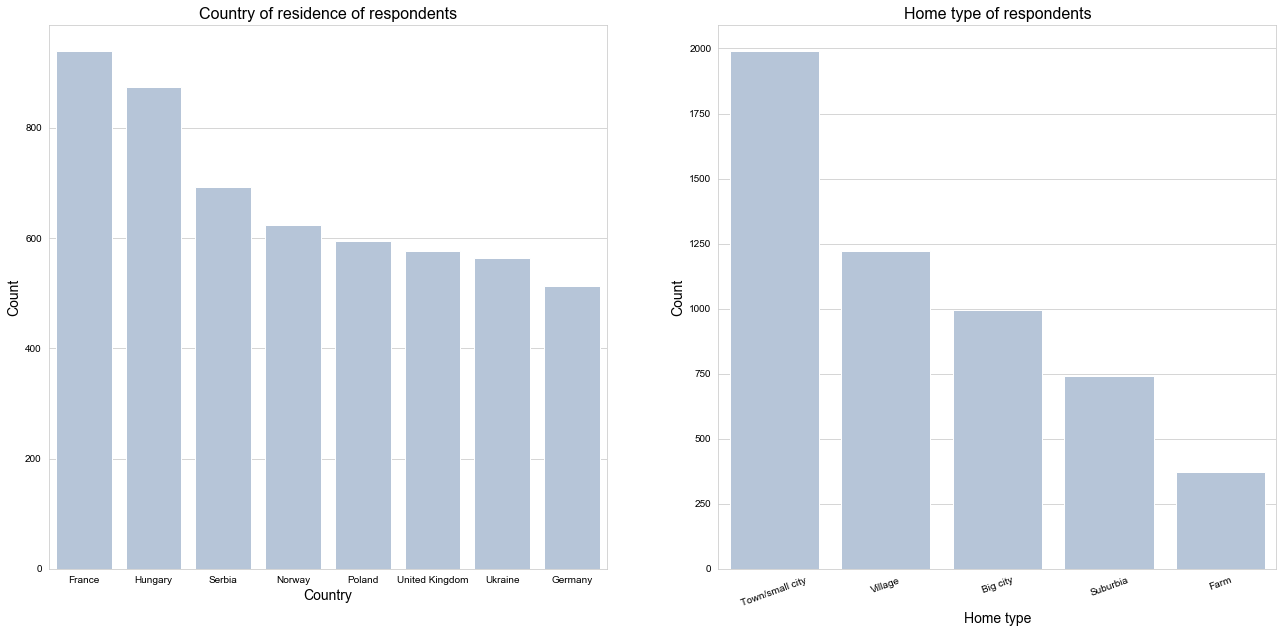

In [81]:
countries = (
    data_main.groupby("Country")["Country"]
    .count()
    .reset_index(name="Count")
    .sort_values(by="Count", ascending=False)
)

fig, axs = plt.subplots(1, 2, figsize=(22, 10))
sns.barplot(x="Country", y="Count", data=countries, color="lightsteelblue", ax=axs[0])
axs[0].set_ylabel("Count", fontsize=14)
axs[0].set_xlabel("Country", fontsize=14)
axs[0].set_title("Country of residence of respondents", fontsize=16)

sns.countplot(
    x="S6",
    data=data_main,
    order=data_main["S6"].value_counts().index,
    ax=axs[1],
    color="lightsteelblue",
)
axs[1].set_xticklabels(
    ["Town/small city", "Village", "Big city", "Suburbia", "Farm", "Refuse"],
    rotation=20,
)
axs[1].set_ylabel("Count", fontsize=14)
axs[1].set_xlabel("Home type", fontsize=14)
axs[1].set_title("Home type of respondents", fontsize=16)

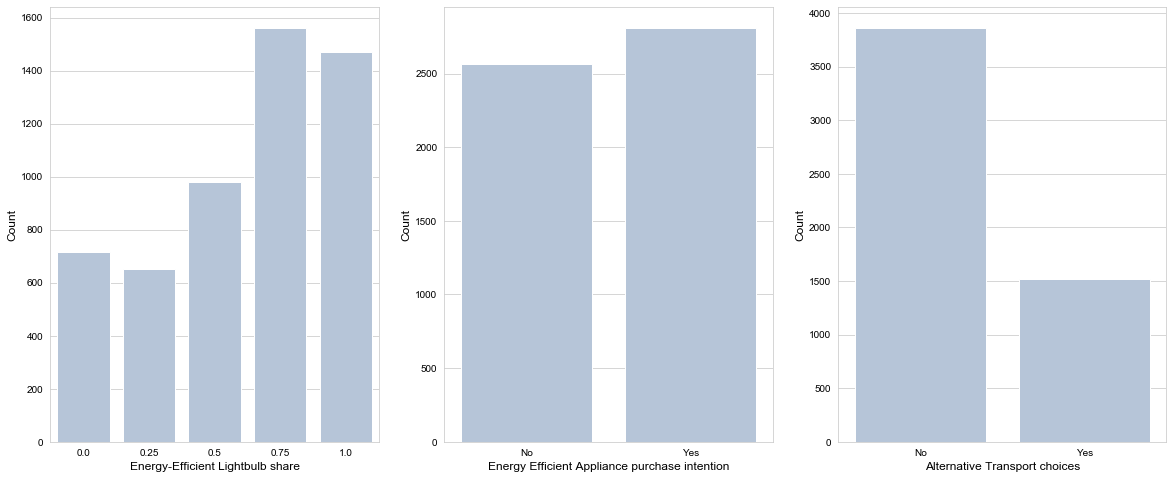

In [82]:
fig, axs = plt.subplots(1,3, figsize=(20, 8))

sns.countplot(
    x="ef_bulbs",
    data=data_main, ax = axs[0], palette=['lightsteelblue'])

axs[0].set_ylabel("Count", fontsize=12)
axs[0].set_xlabel("Energy-Efficient Lightbulb share", fontsize=12)

sns.countplot(
    x="green_3",
    data=data_main, ax = axs[1], palette=['lightsteelblue'])

axs[1].set_xticklabels(
    ["No", "Yes"],
)
axs[1].set_ylabel("Count", fontsize=12)
axs[1].set_xlabel("Energy Efficient Appliance purchase intention", fontsize=12)

sns.countplot(
    x="green_2",
    data=data_main, ax = axs[2], palette=['lightsteelblue'])

axs[2].set_xticklabels(
    ["No", "Yes"],
)
axs[2].set_ylabel("Count", fontsize=12)
axs[2].set_xlabel("Alternative Transport choices", fontsize=12);

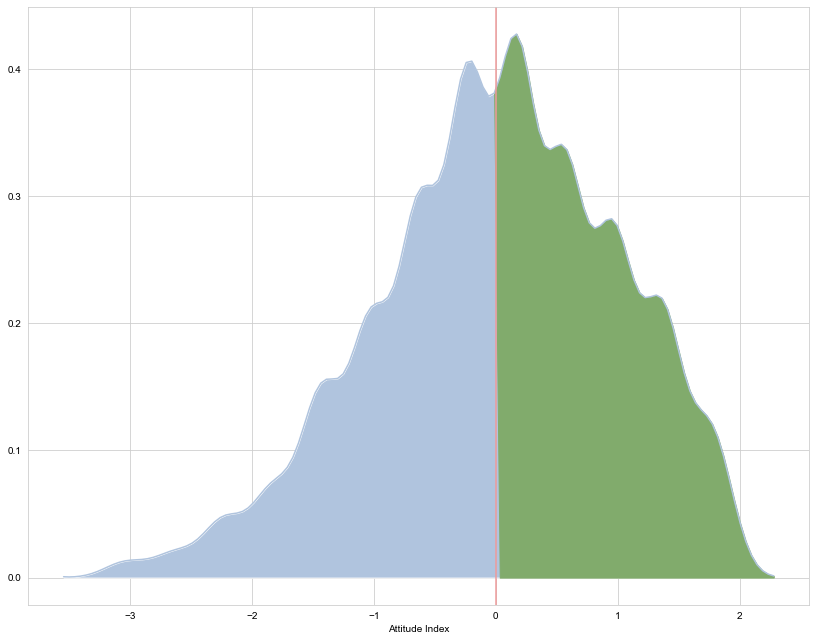

In [92]:
plt.figure(figsize=(14, 11))
ax = sns.distplot(
    data_main["att_2std"].dropna(),
    hist=False,
    color="lightsteelblue",
    kde_kws={"shade": True, "alpha": None},
)
plt.xlabel("Attitude Index")
kde_x, kde_y = ax.lines[0].get_data()
p1 = plt.axvline(x=0, color="#EF9A9A")
ax.fill_between(kde_x, kde_y, where=(kde_x > 0), interpolate=True, color="#81ab6c")

plt.savefig("results/attindexdist.png")

<Figure size 1296x576 with 0 Axes>

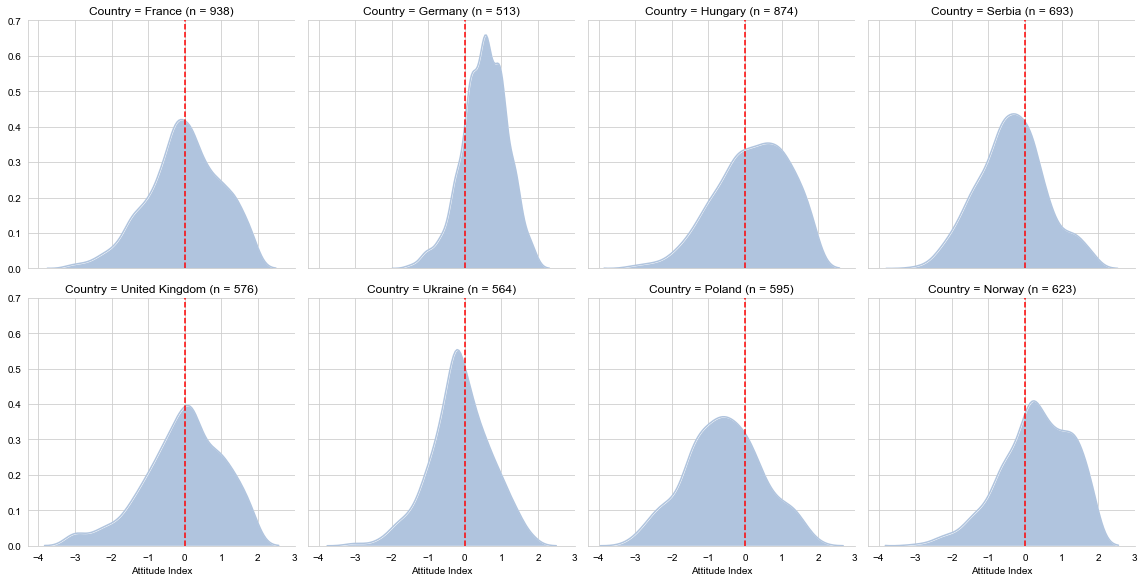

In [88]:
plt.figure(figsize=(18,8))
bins = 12
g = sns.FacetGrid(data_main, col="Country", col_wrap=4, height=4)
g = g.map(
    sns.distplot,
    "att_2std",
    bins=bins,
    color="lightsteelblue",
    hist=False,
    kde_kws={"shade": True,"alpha":None}
)

g.map(plt.axvline, x=0, ls='--', c='red')
        
g.set(ylim=(0, 0.7))

g.axes[0].set_title("Country = France (n = 938)")
g.axes[1].set_title("Country = Germany (n = 513)")
g.axes[2].set_title("Country = Hungary (n = 874)")
g.axes[3].set_title("Country = Serbia (n = 693)")
g.axes[4].set_title("Country = United Kingdom (n = 576)")
g.axes[5].set_title("Country = Ukraine (n = 564)")
g.axes[6].set_title("Country = Poland (n = 595)")
g.axes[7].set_title("Country = Norway (n = 623)")
g.set_xlabels("Attitude Index")